In [1]:
import re
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.model_selection import train_test_split

2024-04-11 04:06:20.066066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 04:06:20.740279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
txt_file = 'data/kor_folk_text.txt'
raw_corpus = []

with open(txt_file, 'r', encoding = 'utf-8') as f:
    raw = f.read().splitlines()
    raw_corpus.extend(raw)
print(len(raw_corpus))

299992


In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()                         #소문자 변경 후 양쪽 공백 제거
    sentence = re.sub(r"([?.!,¿]).,", r" \1 ", sentence)          #특수문자 양쪽에 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)                 #여러 개의 공백이 붙어있으면 하나의 공백으로
    sentence = re.sub(r"[^a-zA-Z가-힣?!¿]+", " ", sentence)   #영어, 알파벳, ?, !, ¿ 제외 모두 공백으로
    sentence = sentence.strip()                                 #양쪽 공백 제거
    sentence = re.sub(r"\(.\)", " ", sentence)                  #괄호 제거
    sentence = '<start> ' + sentence + ' <end>'                 #start, end 추가
    return sentence

In [5]:
corpus = []
for sentence in raw_corpus:
    if len(sentence) == 0:
        continue
    if sentence[-1] == ':':
        continue
    if len(sentence)>150:
        continue

    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)

print(len(corpus))
print(corpus[:10])

146791
['<start> 저 거위도 벽을 넘어 하늘을 날을 거라고 <end>', '<start> 달팽이도 넓고 거친 바다 끝에 꿈을 둔다고 <end>', '<start> 나도 꾸물꾸물 말고 꿈을 찾으래 <end>', '<start> 어서 남의 꿈을 빌려 꾸기라도 해 <end>', '<start> 내게 강요하지 말아요 이건 내 길이 아닌걸 <end>', '<start> 내밀지 말아요 너의 구겨진 꿈을 <end>', '<start> 난 차라리 흘러갈래 <end>', '<start> 모두 높은 곳을 우러러볼 때 <end>', '<start> 난 내 물결을 따라 <end>', '<start> flow flow along flow along my way <end>']


In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 30000, filters = ' ', oov_token = '<unk>')
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding = 'post')
    print('토크나이저: ', tokenizer, '\n', tensor)

    return tensor, tokenizer

In [9]:
tensor, tokenizer = tokenize(corpus)

토크나이저:  <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f3ce6d4bf10> 
 [[    2    61     1 ...     0     0     0]
 [    2     1 10844 ...     0     0     0]
 [    2    80     1 ...     0     0     0]
 ...
 [    2  6756   126 ...     0     0     0]
 [    2 22399   579 ...     0     0     0]
 [    2     4   297 ...     0     0     0]]


In [10]:
tensor.shape

(146791, 26)

In [11]:
for idx in tokenizer.index_word:
    print(idx, ':', tokenizer.index_word[idx])
    if idx>=20: break

1 : <unk>
2 : <start>
3 : <end>
4 : 내
5 : you
6 : i
7 : 난
8 : 그
9 : 수
10 : 내가
11 : 이
12 : 날
13 : 나는
14 : 널
15 : 나
16 : 나의
17 : 너의
18 : 우리
19 : 나를
20 : 그대


In [12]:
#소스 문장과 타겟 문장으로 1차 분리
#tensor에서 마지막 토큰을 잘라내어 소스 문장을, 첫번째 start를 잘라내어 타겟 문장을 생성
#LSTM에서 many-to-many의 답을 얻을 것이므로 위와 같이 구성 <- ????
#이 과정을 통해 src_input과 tgt_input 길이 동일
src_input = tensor[:, :-1]      #start+sentence+end+padding n-1개
tgt_input = tensor[:, 1:]       #sentence+end+padding n개
print('텐서 길이: ', tensor.shape)
print('소스문장 길이: ', len(src_input[0]))
print('타겟문장 길이: ', len(tgt_input[0]))

텐서 길이:  (146791, 26)
소스문장 길이:  25
타겟문장 길이:  25


In [13]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size = 0.2, random_state = 1234)
print('Source Train 길이: ', enc_train.shape)
print('Target Train 길이: ', dec_train.shape)
print('Source Test 길이: ', enc_val.shape)
print('Target Test 길이: ', dec_val.shape)

Source Train 길이:  (117432, 25)
Target Train 길이:  (117432, 25)
Source Test 길이:  (29359, 25)
Target Test 길이:  (29359, 25)


In [14]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epochs = len(src_input) // BATCH_SIZE
VOCAB_SIZE = tokenizer.num_words + 1

dataset_train = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset_train = dataset_train.shuffle(BUFFER_SIZE)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder = True)

dataset_val = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset_val = dataset_val.shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder = True)

print(dataset_train)
print(dataset_val)

2024-04-11 04:06:52.424566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 04:06:52.466378: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 04:06:52.466663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_BatchDataset element_spec=(TensorSpec(shape=(256, 25), dtype=tf.int32, name=None), TensorSpec(shape=(256, 25), dtype=tf.int32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(256, 25), dtype=tf.int32, name=None), TensorSpec(shape=(256, 25), dtype=tf.int32, name=None))>


In [15]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)      #vocab_size로 입력되어서 그걸 embedding_size 만큼으로 표현할 것
        self.rnn_1 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.rnn_2 = tf.keras.layers.SimpleRNN(hidden_size, return_sequences = True)
        self.linear = tf.keras.layers.Dense(vocab_size)     #vocab_size로 줄여야 다음에 무슨 단어를 낼지에 대한 각 클래스 별 수치가 출력

    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)

        return out

In [16]:
embedding_size = 256    #word embedding 차원 수. 즉, 단어가 추상적으로 표현되는 크기 -> dataset의 shape과 같아야 하는거 아닌지???
hidden_size = 1024      #hidden state의 차원 수
model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)
model

<TextGenerator name=text_generator, built=False>

In [17]:
for src_sample, tgt_sample in dataset_train.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 25, 30001), dtype=float32, numpy=
array([[[ 9.02529806e-04,  5.26811834e-03, -6.90805202e-04, ...,
         -8.41204775e-04,  2.36747926e-03,  2.16640270e-04],
        [-8.67462158e-03,  3.46841849e-03, -3.27277300e-03, ...,
         -9.78549593e-04, -1.16236322e-02,  1.92493608e-05],
        [ 8.62796884e-03,  1.29903201e-03,  1.91742983e-02, ...,
          9.45766643e-03, -1.16782039e-02, -7.07189739e-03],
        ...,
        [-7.17244744e-02,  8.21130164e-03,  4.80754673e-02, ...,
         -4.39740531e-02, -1.09009154e-01,  5.79584874e-02],
        [-1.09005114e-02, -9.90985427e-05,  6.03702776e-02, ...,
         -6.09370358e-02,  1.79015510e-02,  3.08117494e-02],
        [-4.68025208e-02,  6.63106963e-02,  4.76796217e-02, ...,
         -1.15782894e-01, -5.74034117e-02,  7.90998414e-02]],

       [[ 9.02529806e-04,  5.26811834e-03, -6.90805202e-04, ...,
         -8.41204775e-04,  2.36747926e-03,  2.16640270e-04],
        [-4.72304597e-03,  4.62814048e-03, -6

In [18]:
model.summary()

Model: "text_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,680,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │    30,751,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,841,201 (159.61 MB)

 Trainable params: 41,841,201 (159.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = 'none')

In [21]:
model.compile(loss = loss, optimizer = optimizer)
model.fit(dataset_train, epochs = 10)

Epoch 1/10


I0000 00:00:1712808429.889346  438969 service.cc:145] XLA service 0xbaeb0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712808429.889388  438969 service.cc:153]   StreamExecutor device (0): NVIDIA A16-16Q, Compute Capability 8.6
2024-04-11 04:07:09.934231: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 04:07:10.402934: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1712808433.199097  439042 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 84 bytes spill stores, 84 bytes spill loads

I0000 00:00:1712808433.376564  439038 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_61', 1740 bytes spill stores, 2152 bytes spill loads

I0000 00:00:1712808434.0

458/458 ━━━━━━━━━━━━━━━━━━━━ 159s 326ms/step - loss: 1.9569
Epoch 2/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 328ms/step - loss: 1.2837
Epoch 3/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 328ms/step - loss: 1.1732
Epoch 4/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 328ms/step - loss: 1.0615
Epoch 5/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 328ms/step - loss: 0.9446
Epoch 6/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 328ms/step - loss: 0.8327
Epoch 7/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 327ms/step - loss: 0.7421
Epoch 8/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 326ms/step - loss: 0.6820
Epoch 9/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 149s 326ms/step - loss: 0.6413
Epoch 10/10
458/458 ━━━━━━━━━━━━━━━━━━━━ 150s 326ms/step - loss: 0.6129


In [22]:
model.save('rnn_kor_folk.keras')
tf.saved_model.save(model, 'rnn_kor_folk.tf')

INFO:tensorflow:Assets written to: rnn_kor_folk.tf/assets


INFO:tensorflow:Assets written to: rnn_kor_folk.tf/assets


In [23]:
def generate_text(model, tokenizer, init_sentence = '<start>', max_len = 30):
    #테스트를 위해 입력받은 init_sentence도 텐서 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype = tf.int64)
    end_token = tokenizer.word_index['<end>']

    #단어를 하나씩 예측해 문장 생성
    while True:
        #1. 입력받은 문장의 텐서 입력
        predict = model(test_tensor)
        #2. 예측된 값 중 가장 높은 확률인 word index를 출력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis = -1), axis = -1)[:, -1]
        #3. 2에서 예측된 word index를 문장 뒤에 붙임
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis = 0)], axis = -1)
        #4. 모델이 <end>를 예측했거나 max_len에 도달하면 문장 생성을 마침
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ''
    #tokenizer를 활용해 word index를 단어로 하나씩 변환
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + ' '

    return generated

In [24]:
generate_text(model, tokenizer, init_sentence = '<start> i')

'<start> i ll take you into my loving arms <end> '

In [25]:
generate_text(model, tokenizer, init_sentence = '<start> 나')

'<start> 나 가고 싶다 너의 마음으로 <end> '

In [26]:
generate_text(model, tokenizer, init_sentence = '<start> 나', max_len = 50)

'<start> 나 가고 싶다 너의 마음으로 <end> '

In [27]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑해')

'<start> 사랑해 널 사랑해 <end> '

In [28]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑은')

'<start> 사랑은 받는 것이 아니라면서 <end> '

In [29]:
generate_text(model, tokenizer, init_sentence = '<start> 사랑이')

'<start> 사랑이 아니었음을 <end> '

folk_이번 봄 캐롤의 주인공은 너랑 나 - 둔둔  
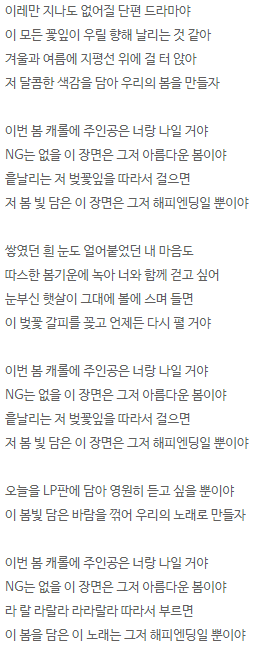

In [30]:
carol = ['이레', '이', '겨울', '저', '이번', 'ng', '흩날리는', '쌓였던', '따스한', '눈부신']
for word in carol:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> <unk> <unk> <end> 
<start> 이 밤 또 노래를 불러야지 <end> 
<start> 겨울 밤 막다른 골목길 포장마차에서 <end> 
<start> 저 멀리서 니 향기가 <end> 
<start> 이번 봄에 말이야 <end> 
<start> <unk> <unk> <end> 
<start> 흩날리는 거리에서 <end> 
<start> 쌓였던 먼지를 털어내고 <end> 
<start> 따스한 온기를 나누리 <end> 
<start> 눈부신 그 밤을 <end> 


all genre_임수-goood  
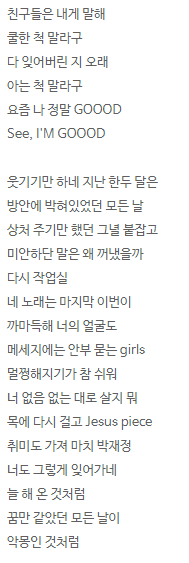

In [31]:
goood = ['친구들은', '쿨한', '다', '아는', '요즘', 'see', '웃기기만', '방안에', '상처', '미안하단']
for word in goood:
    word = '<start> ' + word
    print(generate_text(model, tokenizer, init_sentence = word))

<start> 친구들은 모두 다 말했지 <end> 
<start> 쿨한 척 굴었어요 <end> 
<start> 다 잊어지겠지 <end> 
<start> 아는 <unk> <end> 
<start> 요즘 처럼 날에 <end> 
<start> see the light in the dark <end> 
<start> <unk> <unk> <end> 
<start> 방안에 누워 <end> 
<start> 상처 받은 마음을 <end> 
<start> 미안하단 말 한마디가 내내 맴돌아 <end> 


: 